In [44]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt

from baum_welch_jax.algorithms import baum_welch, generate_sequence
from baum_welch_jax.models import HiddenMarkovModel



jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [45]:
from matplotlib.figure import Figure
import numpy as np

def plot_hmm_params(hmm: HiddenMarkovModel) -> tuple[Figure, np.ndarray]:
    n, m = hmm.O.shape
    fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
    fig.set_size_inches(5,2)

    if hmm.is_log:
        hmm = hmm.to_prob()

    ax[0].imshow(hmm.T)
    ax[0].set_title("T")
    ax[1].imshow(hmm.O)
    ax[1].set_title("O")
    ax[2].imshow(hmm.mu[:,None])
    ax[2].set_title(r"$\mu$")
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    return fig, ax

In [46]:
T = jnp.array(
    [
        [0.9, 0.1], 
        [0.1,0.9]
    ]
)
O = jnp.eye(2)
mu = jnp.array([0.0, 1.0])
hmm = HiddenMarkovModel(T, O, mu)

init_guess = HiddenMarkovModel(
    jnp.ones((2,2)) / 2, 
    jnp.ones((2,2)) / 2, 
    jnp.array([0.2,0.8]))

states, obs = generate_sequence(key(0), hmm, 500)
result = baum_welch(obs, init_guess, max_iter=5000, epsilon=1e-6, mode='log')

obs


Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

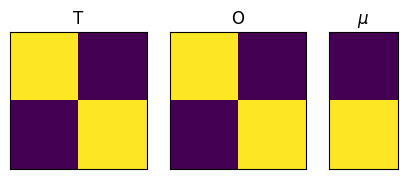

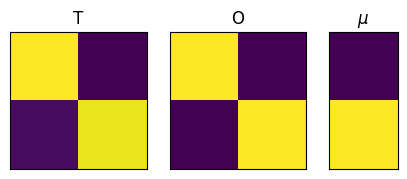

Likelihood is nondecreasing: True


In [47]:


fig, ax = plot_hmm_params(hmm)
plt.show()

fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))


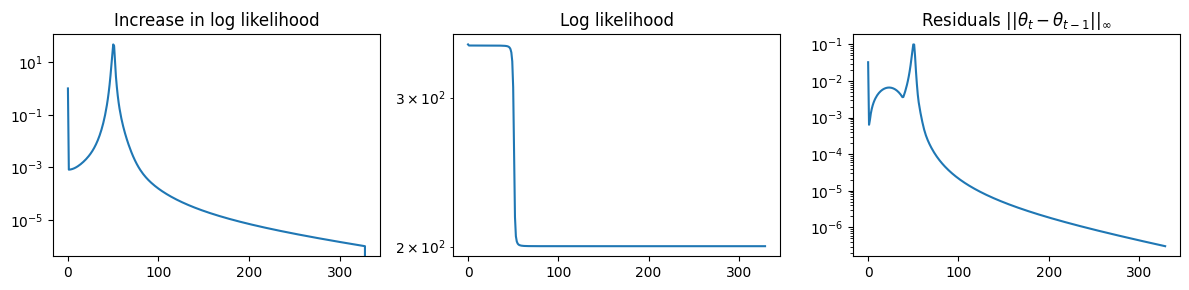

330 False


HiddenMarkovModel(T=Array([[0.872, 0.128],
       [0.15 , 0.85 ]], dtype=float64), O=Array([[1.000e+00, 2.527e-05],
       [1.562e-34, 1.000e+00]], dtype=float64), mu=Array([0., 1.], dtype=float64), is_log=False)

In [48]:

def plot_inference_statistics(result):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12,3)
    ax[0].semilogy(jnp.diff(result.log_likelihoods))
    ax[0].set_title('Increase in log likelihood')
    ax[1].semilogy(jnp.abs(result.log_likelihoods[:result.iterations]))
    ax[1].set_title('Log likelihood')
    ax[2].semilogy(result.residuals)
    ax[2].set_title('Residuals $||\\theta_t - \\theta_{{t-1}}||_\\infty$')
    fig.tight_layout()
    return fig, ax

plot_inference_statistics(result)
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

In [49]:
seed = 2345
n = 4 # Number of states
m = 3 # Number of observations
# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.95 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.05 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jnp.zeros((n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
O = O.at[0, 0].set(1.0)
for s in range(n):
    O = O.at[s].set(jnp.exp(- ((jnp.arange(m) - (s*m) / n)**2)/(s + 1)))
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

hmm = HiddenMarkovModel(T, O, mu)

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])


T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


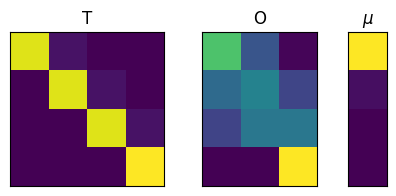

In [50]:
fig, ax = plot_hmm_params(hmm)
plt.show()

In [51]:
from baum_welch_jax.algorithms import generate_sequence

n_sequences = 100
len_sequence = 100
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (100, 100)


In [52]:
key_T, key_O, key_mu = split(key(0), 3)

_T = uniform(key_T, T.shape)
_O = uniform(key_O, O.shape)
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)


init_guess = HiddenMarkovModel(_T, _O, _mu)
result = baum_welch(observations, init_guess, max_iter=5000, epsilon=1e-10, mode='log')

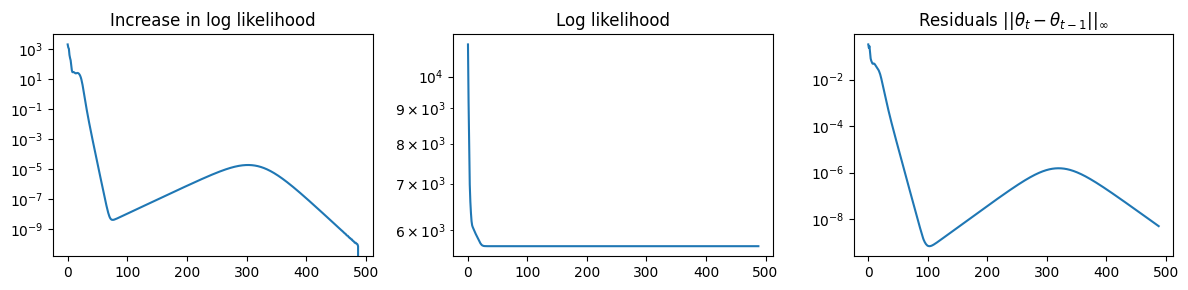

489 False


HiddenMarkovModel(T=Array([[6.179e-001, 6.031e-006, 8.172e-090, 3.821e-001],
       [1.145e-002, 9.707e-001, 2.875e-003, 1.499e-002],
       [2.253e-307, 5.033e-002, 9.497e-001, 4.958e-306],
       [5.960e-001, 3.103e-005, 1.072e-087, 4.040e-001]], dtype=float64), O=Array([[1.414e-146, 0.000e+000, 1.000e+000],
       [2.653e-001, 4.364e-001, 2.983e-001],
       [6.945e-001, 2.844e-001, 2.110e-002],
       [5.681e-142, 0.000e+000, 1.000e+000]], dtype=float64), mu=Array([0., 0., 1., 0.], dtype=float64), is_log=False)

In [53]:
plot_inference_statistics(result)
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

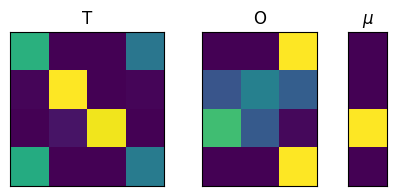

Likelihood is nondecreasing: True


In [54]:
fig, ax = plot_hmm_params(result.params)
plt.show()

print('Likelihood is nondecreasing:', bool(jnp.all(jnp.diff(result.log_likelihoods[:result.iterations]) >= 0)))

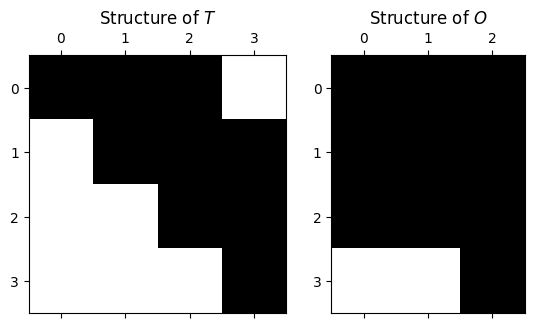

In [55]:
T_structure = jnp.tril(jnp.triu(jnp.ones_like(T, dtype=jnp.float64)), 2)
O_structure = jnp.ones_like(O, dtype=jnp.float64)
O_structure = O_structure.at[n-1, :m-1].set(0)

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
plt.show()

In [56]:
key_T, key_O, key_mu = split(key(334), 3)

_T = uniform(key_T, T.shape) * T_structure
_O = uniform(key_O, O.shape) * O_structure
_mu = uniform(key_mu, mu.shape)


_T = _T / jnp.sum(_T, axis=1)[:, None]
_O = _O / jnp.sum(_O, axis=1)[:, None]
_mu = _mu / jnp.sum(_mu)
init_guess = HiddenMarkovModel(_T, _O, _mu)
result = baum_welch(observations, init_guess, max_iter=1000, epsilon=1e-10, mode='log')

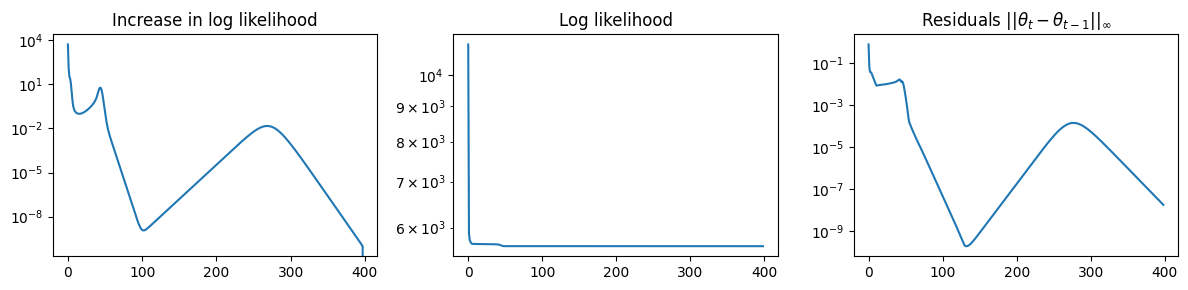

399 False


HiddenMarkovModel(T=Array([[0.947, 0.046, 0.007, 0.   ],
       [0.   , 0.96 , 0.035, 0.004],
       [0.   , 0.   , 0.95 , 0.05 ],
       [0.   , 0.   , 0.   , 1.   ]], dtype=float64), O=Array([[0.715, 0.268, 0.017],
       [0.36 , 0.449, 0.191],
       [0.193, 0.406, 0.401],
       [0.   , 0.   , 1.   ]], dtype=float64), mu=Array([1., 0., 0., 0.], dtype=float64), is_log=False)

In [57]:
plot_inference_statistics(result)
plt.show()

print(result.iterations, result.terminated)
result.params.to_prob()

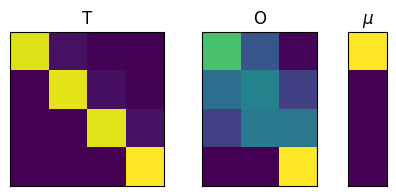

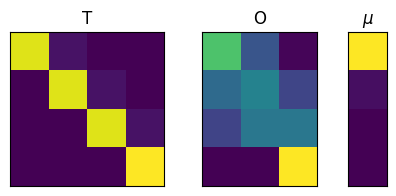

In [58]:
fig, ax = plot_hmm_params(result.params)
plt.show()

fig, ax = plot_hmm_params(hmm)
plt.show()


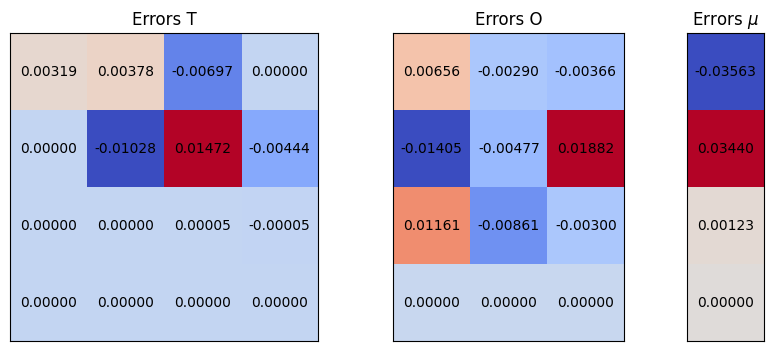

In [59]:
import numpy as np
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(10,4)

res_hmm = result.params.to_prob()

errors = [
    T - res_hmm.T,
    O - res_hmm.O,
    mu[:,None] - res_hmm.mu[:,None]
]

labels = [
    'T',
    'O',
    '$\\mu$'
]

for k, (err_mat, label) in enumerate(zip(errors, labels)):
    ax[k].matshow(err_mat, cmap='coolwarm')
    for (i, j), z in np.ndenumerate(err_mat):
        ax[k].text(j, i, '{:0.5f}'.format(z), ha='center', va='center')
    ax[k].set_title(f"Errors {label}")
    ax[k].set_xticks([])
    ax[k].set_yticks([])
plt.show()

In [60]:
from baum_welch_jax.algorithms import likelihood

def plot_stats(states, observations):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    _, likelihoods = jax.vmap(lambda obs_seq: likelihood(obs_seq, hmm, return_stats=True))(observations)
    ax[1].set_title("Mean likelihoods vs. sequence length")
    ax[1].plot(jnp.mean(likelihoods, axis=0))
    ax[1].set_xlabel("Sequence length")
    ax[1].set_ylabel("Mean likelihood")
    ax[1].grid()

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(m)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[2].plot(obs_prob, label=f"$o^{k}$")
    ax[2].set_title("Observation distribution over time")
    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("Time step")
    ax[2].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[3].plot(state_prob, label=f"$s^{k}$")

    ax[3].set_title("State distribution over time")
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("$p(s_t)$")
    ax[3].grid()
    ax[3].legend()

    plt.tight_layout()
    plt.show()



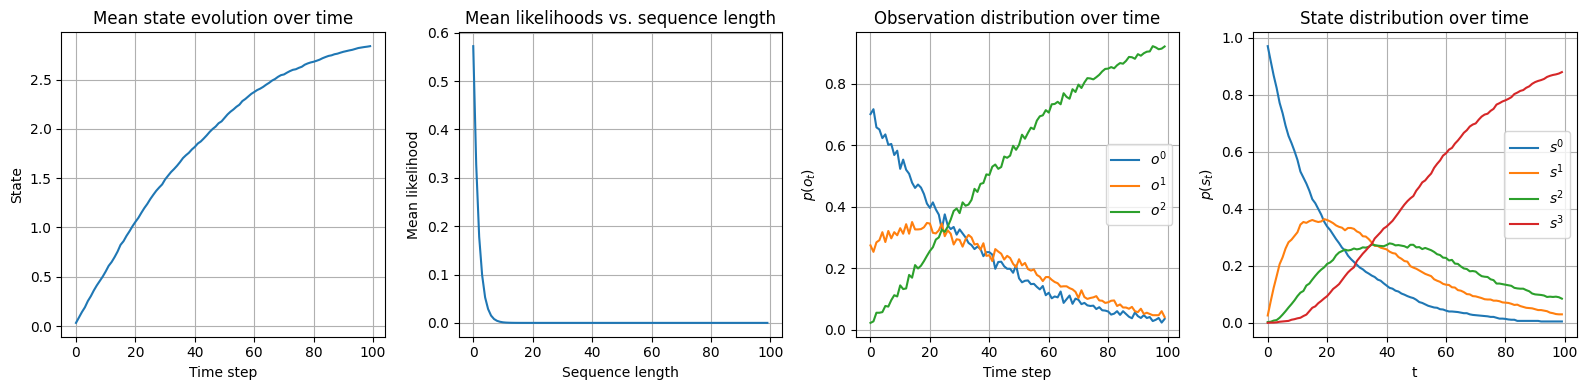

In [61]:
n_sequences = 1000
len_sequence = 100
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, hmm, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)

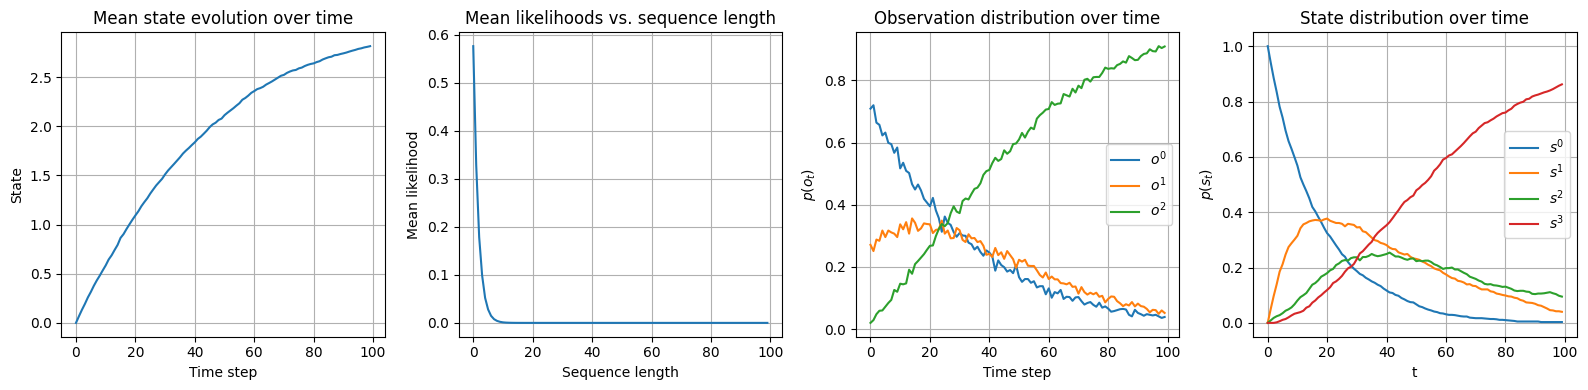

In [62]:
generate = jax.jit(lambda _key: generate_sequence(_key, result.params, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

plot_stats(states, observations)